In [ ]:
import h5py

base_dataset = h5py.File("/content/drive/MyDrive/precognet-dataset-all-25.h5", 'r')

In [ ]:
import numpy as np
from keras.src.utils import to_categorical

dataset_features = np.concatenate((np.array(base_dataset.get('fight-features')), np.array(base_dataset.get('non-fight-features'))), axis=0)
dataset_labels = np.concatenate((base_dataset.get('fight-labels'), base_dataset.get('non-fight-labels')), axis=0).reshape(-1, 1)

print (sum(np.array_equal(item, [0]) for item in dataset_labels))

6000


In [ ]:
print (sum(np.array_equal(item, [1]) for item in dataset_labels))

6000


In [ ]:
print (len(set(dataset_labels.flatten())))

2


In [ ]:
from keras.src.models import Sequential
from keras.src.layers import *
from keras.src.applications.mobilenet_v2 import MobileNetV2

def model():
    mobilenet = MobileNetV2(
        include_top=False, weights="imagenet", input_shape=(64, 64, 3)
    )
    mobilenet.trainable = False

    model = Sequential()

    model.add(Input(shape=(25, 64, 64, 3)))

    model.add(TimeDistributed(mobilenet))

    model.add(ConvLSTM2D(filters=64, kernel_size=(3, 3), activation='tanh', padding='same'))

    model.add(Flatten())
    model.add(Dropout(0.5))

    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(1, activation='sigmoid'))

    return model

In [ ]:
from keras.src.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from keras.src.optimizers import Adam
import tensorflow as tf
import random
from keras import backend as K

def reset_seeds():
    np.random.seed(1)
    random.seed(2)
    if tf.__version__[0] == '2':
        tf.random.set_seed(3)
    else:
        tf.set_random_seed(3)
    print("RANDOM SEEDS RESET")

early_stopping_callback = EarlyStopping(
    monitor='accuracy',
    patience=5,
    restore_best_weights=True
)



In [ ]:
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, f1_score, roc_auc_score, roc_curve, log_loss, matthews_corrcoef
import time

# Instantiate the cross validator
skf = StratifiedKFold(n_splits=5, shuffle=True)
splits = skf.split(dataset_features, dataset_labels)
# Loop through the indices the split() method returns

accuracies = []
f1_scores = []
precisions = []
recalls = []
log_losses = []
matrices = []
training_histories = []
roc_aucs = []
reports = []
training_times = []
specs = []
mccs = []

for index, (train_indices, test_indices) in enumerate(splits):
    print ("Training on fold " + str(index+1) + "/5...")

    # Separando os dados de treino e teste
    xtrain, xtest = dataset_features[train_indices], dataset_features[test_indices]
    ytrain, ytest = dataset_labels[train_indices], dataset_labels[test_indices]

    print ("-------------------------------------------------------")
    print (f"[Training] Sample Size for Fighting: {sum(np.array_equal(item, [1]) for item in ytrain)}")
    print (f"[Training] Sample Size for Non-Fighting: {sum(np.array_equal(item, [0]) for item in ytrain)}")
    print (f"[Testing]  Sample Size for Fighting: {sum(np.array_equal(item, [0]) for item in ytest)}")
    print (f"[Testing]  Sample Size for Non-Fighting: {sum(np.array_equal(item, [0]) for item in ytest)}")
    print ("-------------------------------------------------------")

    checkpoint = ModelCheckpoint(
        filepath=f'model_fold_{index+1}.keras',
        monitor='accuracy',
        mode='max',
        save_best_only=True,
        verbose=1
    )

    reduce_lr = ReduceLROnPlateau(
        monitor='loss',
        factor=0.6,
        patience=5,
        min_lr=0.00005,
        verbose=1
    )

    reset_seeds()
    strategy = tf.distribute.MirroredStrategy()
    with strategy.scope():
      model_pipeline = model()
      model_pipeline.compile(
          loss="binary_crossentropy",
          optimizer=Adam(learning_rate=0.0001),
          metrics=["accuracy"]
      )

    start_time = time.time()
    history = model_pipeline.fit(
        xtrain, ytrain, epochs=30,
        callbacks=[reduce_lr,checkpoint]
    )
    training_time = time.time() - start_time
    training_times.append(training_time)

    model_evaluation_history = model_pipeline.evaluate(xtest, ytest)
    print (model_evaluation_history)

    labels_predict = model_pipeline.predict(xtest)

    # Decoding the data to use in Metrics
    labels_predict = (labels_predict > 0.5).astype(int)

    # Se os rótulos de teste forem one-hot, converta para binários
    labels_test_normal = np.argmax(ytest, axis=1)

    report = classification_report(ytest, labels_predict, target_names=['Violência', 'Não Violência'], digits=4)
    print (report)

    accuracy = accuracy_score(ytest, labels_predict)
    precision = precision_score(ytest, labels_predict)
    recall = recall_score(ytest, labels_predict)
    f1 = f1_score(ytest, labels_predict)
    cm = confusion_matrix(ytest, labels_predict)
    tn, fp, fn, tp = cm.ravel()
    specificity = tn / (tn + fp)
    auc_score = roc_auc_score(ytest, labels_predict)
    lg_loss = log_loss(ytest, labels_predict)
    mcc = matthews_corrcoef(ytest, labels_predict)

    print("Tempo de treinamento:", training_time)
    print("Acurácia:", accuracy)
    print("Precisão:", precision)
    print("Recall:", recall)
    print("F1-score:", f1)
    print("AUC:", auc_score)
    print("Especificidade:", specificity)
    print("MCC:", mcc)
    print("Log loss:", lg_loss)
    print("Matriz de Confusão:\n", cm)
    print("-------------------------------------------")

    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)
    specs.append(specificity)
    mccs.append(mcc)
    matrices.append(cm)
    reports.append(report)
    log_losses.append(lg_loss)
    roc_aucs.append(auc_score)

    del model_pipeline
    K.clear_session()
    tf.compat.v1.reset_default_graph()

Training on fold 1/5...
-------------------------------------------------------
[Training] Sample Size for Fighting: 4800
[Training] Sample Size for Non-Fighting: 4800
[Testing]  Sample Size for Fighting: 1200
[Testing]  Sample Size for Non-Fighting: 1200
-------------------------------------------------------
RANDOM SEEDS RESET


<ipython-input-5-ed33be561e42>:6: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  mobilenet = MobileNetV2(


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.6133 - loss: 0.6520
Epoch 1: accuracy improved from -inf to 0.67833, saving model to model_fold_1.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 94s 126ms/step - accuracy: 0.6135 - loss: 0.6518 - learning_rate: 1.0000e-04
Epoch 2/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.8082 - loss: 0.4108
Epoch 2: accuracy improved from 0.67833 to 0.82990, saving model to model_fold_1.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 38s 126ms/step - accuracy: 0.8083 - loss: 0.4106 - learning_rate: 1.0000e-04
Epoch 3/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.8893 - loss: 0.2581
Epoch 3: accuracy improved from 0.82990 to 0.90052, saving model to model_fold_1.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 38s 127ms/step - accuracy: 0.8894 - loss: 0.2581 - learning_rate: 1.0000e-04
Epoch 4/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.9299 - loss: 0.1704
Epoch 4: accuracy impro

<ipython-input-5-ed33be561e42>:6: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  mobilenet = MobileNetV2(


Epoch 1/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.6008 - loss: 0.6619
Epoch 1: accuracy improved from -inf to 0.67198, saving model to model_fold_2.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 93s 130ms/step - accuracy: 0.6010 - loss: 0.6617 - learning_rate: 1.0000e-04
Epoch 2/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.8025 - loss: 0.4112
Epoch 2: accuracy improved from 0.67198 to 0.82792, saving model to model_fold_2.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 39s 129ms/step - accuracy: 0.8026 - loss: 0.4110 - learning_rate: 1.0000e-04
Epoch 3/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.8944 - loss: 0.2523
Epoch 3: accuracy improved from 0.82792 to 0.90677, saving model to model_fold_2.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 38s 127ms/step - accuracy: 0.8944 - loss: 0.2522 - learning_rate: 1.0000e-04
Epoch 4/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.9362 - loss: 0.1665
Epoch 4: accuracy improved from 0.90677 to 0.93563, saving model to mode

<ipython-input-5-ed33be561e42>:6: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  mobilenet = MobileNetV2(


Epoch 1/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.5967 - loss: 0.6591
Epoch 1: accuracy improved from -inf to 0.65990, saving model to model_fold_3.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 94s 129ms/step - accuracy: 0.5969 - loss: 0.6589 - learning_rate: 1.0000e-04
Epoch 2/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.8146 - loss: 0.4098
Epoch 2: accuracy improved from 0.65990 to 0.83729, saving model to model_fold_3.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 38s 127ms/step - accuracy: 0.8146 - loss: 0.4097 - learning_rate: 1.0000e-04
Epoch 3/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.8938 - loss: 0.2475
Epoch 3: accuracy improved from 0.83729 to 0.90333, saving model to model_fold_3.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 38s 127ms/step - accuracy: 0.8939 - loss: 0.2474 - learning_rate: 1.0000e-04
Epoch 4/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.9324 - loss: 0.1808
Epoch 4: accuracy improved from 0.90333 to 0.93594, saving model to mode

<ipython-input-5-ed33be561e42>:6: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  mobilenet = MobileNetV2(


Epoch 1/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.6190 - loss: 0.6487
Epoch 1: accuracy improved from -inf to 0.67521, saving model to model_fold_4.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 91s 128ms/step - accuracy: 0.6191 - loss: 0.6485 - learning_rate: 1.0000e-04
Epoch 2/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.8047 - loss: 0.4212
Epoch 2: accuracy improved from 0.67521 to 0.82771, saving model to model_fold_4.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 39s 128ms/step - accuracy: 0.8047 - loss: 0.4210 - learning_rate: 1.0000e-04
Epoch 3/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.9008 - loss: 0.2441
Epoch 3: accuracy improved from 0.82771 to 0.90958, saving model to model_fold_4.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 38s 128ms/step - accuracy: 0.9008 - loss: 0.2441 - learning_rate: 1.0000e-04
Epoch 4/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.9317 - loss: 0.1694
Epoch 4: accuracy improved from 0.90958 to 0.93854, saving model to mode

<ipython-input-5-ed33be561e42>:6: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  mobilenet = MobileNetV2(


Epoch 1/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.6199 - loss: 0.6472
Epoch 1: accuracy improved from -inf to 0.68073, saving model to model_fold_5.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 91s 127ms/step - accuracy: 0.6202 - loss: 0.6470 - learning_rate: 1.0000e-04
Epoch 2/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.8075 - loss: 0.4172
Epoch 2: accuracy improved from 0.68073 to 0.83094, saving model to model_fold_5.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 38s 127ms/step - accuracy: 0.8075 - loss: 0.4171 - learning_rate: 1.0000e-04
Epoch 3/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.8883 - loss: 0.2585
Epoch 3: accuracy improved from 0.83094 to 0.90510, saving model to model_fold_5.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 38s 127ms/step - accuracy: 0.8883 - loss: 0.2584 - learning_rate: 1.0000e-04
Epoch 4/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.9319 - loss: 0.1723
Epoch 4: accuracy improved from 0.90510 to 0.93479, saving model to mode

In [ ]:
mean_accuracy = np.mean(accuracies)
mean_f1_score = np.mean(f1_scores)
mean_precisions = np.mean(precisions)
mean_recall = np.mean(recalls)
spec_final = np.mean(specs)
mcc_final = np.mean(mccs)
# mean_log_loss = np.mean(log_loss)
mean_roc_auc = np.mean(roc_aucs)
mean_training_time = np.mean(training_times)

print(f"Acurácia: {mean_accuracy} = {accuracies}")
print(f"Precisão: {mean_precisions} => {precisions}")
print(f"Recall: {mean_recall} => {recalls}")
print(f"F1-score: {mean_f1_score} => {f1_scores}")
print(f"Especificidade: {spec_final} => {specs}")
print(f"MCC: {mcc_final} => {mccs}")
print(f"AUC: {mean_roc_auc} => {roc_aucs}")
print(f"Training Time: {mean_training_time} => {training_times} | Sum: {sum(training_times)}")
print(f"Log loss:", log_loss)

Acurácia: 0.9599166666666668 = [0.96625, 0.96125, 0.955, 0.9579166666666666, 0.9591666666666666]
Precisão: 0.9582661277130432 => [0.9713563605728728, 0.9474535165723524, 0.9542429284525791, 0.9724849527085124, 0.9457928802588996]
Recall: 0.9620000000000001 => [0.9608333333333333, 0.9766666666666667, 0.9558333333333333, 0.9425, 0.9741666666666666]
F1-score: 0.9599939649269587 => [0.9660661918726435, 0.9618383258104226, 0.95503746877602, 0.9572577232331781, 0.9597701149425287]
Especificidade: 0.9578333333333333 => [0.9716666666666667, 0.9458333333333333, 0.9541666666666667, 0.9733333333333334, 0.9441666666666667]
MCC: 0.9201021308709441 => [0.932554724434993, 0.9229388207256196, 0.9100012638915219, 0.91626898281613, 0.918746862486456]
AUC: 0.9599166666666668 => [0.96625, 0.9612499999999999, 0.9550000000000001, 0.9579166666666666, 0.9591666666666667]
Training Time: 1246.8974792957306 => [1257.1087629795074, 1256.1939084529877, 1243.045688867569, 1240.364002943039, 1237.77503323555] | Sum:

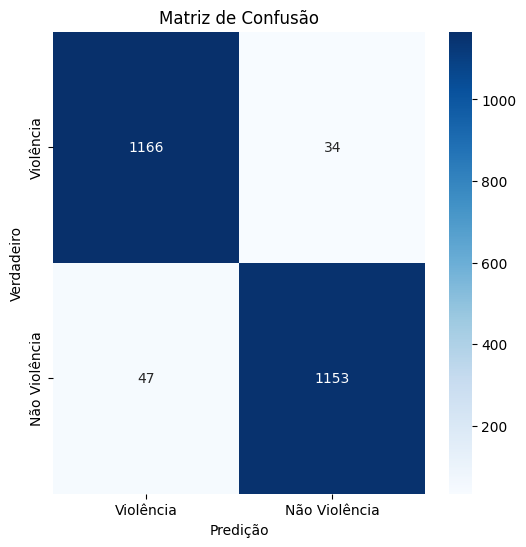

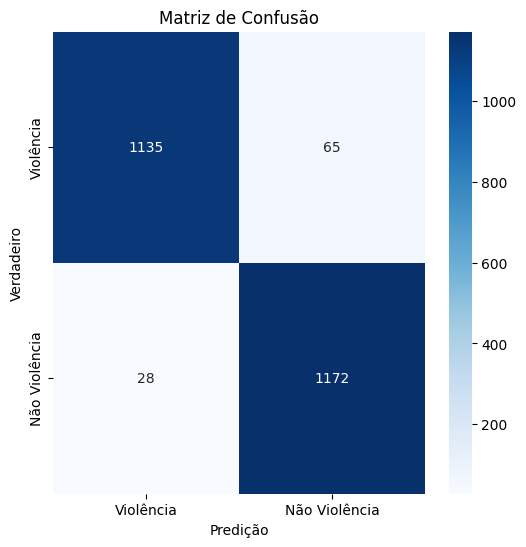

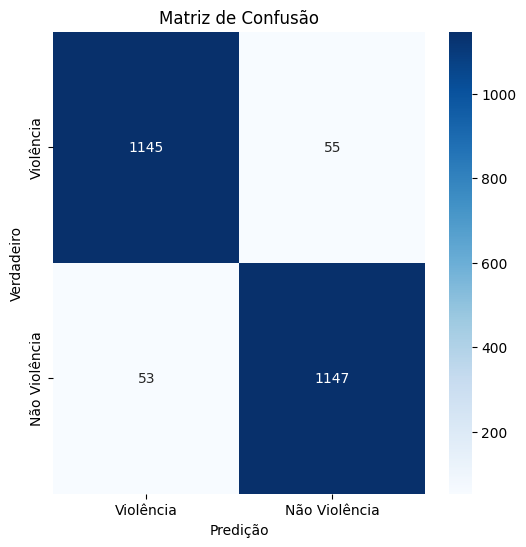

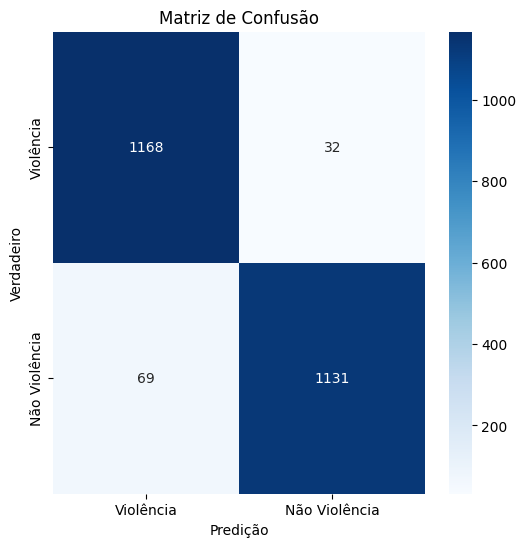

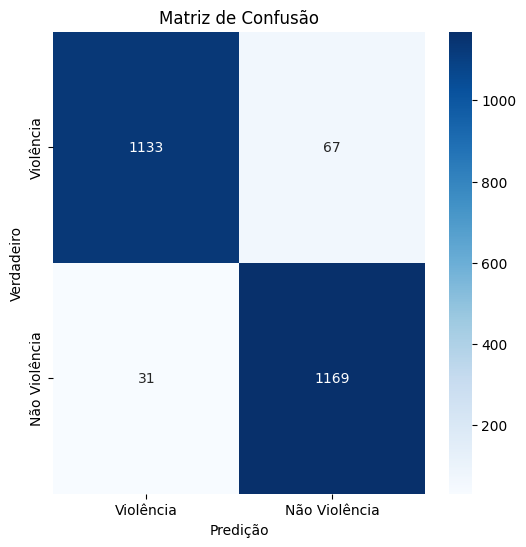

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

for conf_matrix in matrices:
  plt.figure(figsize=(6, 6))
  sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Violência', 'Não Violência'], yticklabels=['Violência', 'Não Violência'])
  plt.xlabel('Predição')
  plt.ylabel('Verdadeiro')
  plt.title('Matriz de Confusão')
  plt.show()